Import

In [2]:
#import
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

C:\Users\buian\anaconda3\envs\tf-gpu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


**LoadData**

In [3]:
#
images = []
ages = []

for i in os.listdir('/kaggle/input/face-utk/Face_Detection/Face_Detection'):
    split = i.split('_')
    ages.append(int(split[0]))

    images.append(Image.open('/kaggle/input/face-utk/Face_Detection/Face_Detection/' + i))

In [4]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')

df = pd.concat([images, ages], axis=1)
df

,Images,Ages
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,26
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,21
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,17
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,76
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,18
...,...,...
9775,<PIL.JpegImagePlugin.JpegImageFile image mode=...,26
9776,<PIL.JpegImagePlugin.JpegImageFile image mode=...,66
9777,<PIL.JpegImagePlugin.JpegImageFile image mode=...,41
9778,<PIL.JpegImagePlugin.JpegImageFile image mode=...,2


/tmp/ipykernel_35/1271551252.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Ages'],kde=True, bins=30)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Ages', ylabel='Density'>

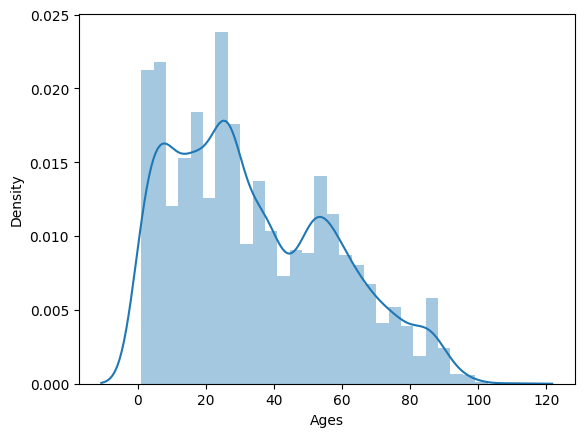

In [5]:
# chỉ đưa vào 1/3 số tuổi từ 0 đến 4 vì ở tuổi này có quá nhiều
under4s = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)

df = df[df['Ages'] > 4]

df = pd.concat([df, under4s], ignore_index = True)
sns.distplot(df['Ages'],kde=True, bins=30)

/tmp/ipykernel_35/1342543998.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Ages'],kde=True, bins=20)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Ages', ylabel='Density'>

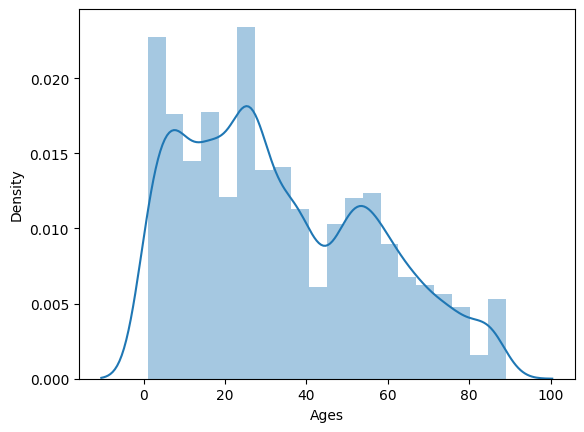

In [6]:
# loại bỏ tuổi từ 99 trở đi vì có ít dữ liệu
df = df[df['Ages'] < 90]
sns.distplot(df['Ages'],kde=True, bins=20)

In [7]:
x = []
y = []

for _, row in df.iterrows():
    # Resize ảnh
    img_resized = row['Images'].resize((200, 200), Image.Resampling.LANCZOS)
    # Chuyển sang array
    img_array = np.asarray(img_resized)
    x.append(img_array)

    # Lưu nhãn
    age = int(row['Ages'])
    y.append([age])

x = np.array(x)
y = np.array(y)

**Train test split**

In [8]:
y_age = df['Ages']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)

In [3]:
agemodel = Sequential()

agemodel.add(Conv2D(64, (3,3), activation='relu'))
agemodel.add(BatchNormalization())
agemodel.add(MaxPooling2D((2,2)))

agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(BatchNormalization())
agemodel.add(MaxPooling2D((2,2)))

agemodel.add(Conv2D(256, (3,3), activation='relu'))
agemodel.add(BatchNormalization())
agemodel.add(MaxPooling2D((2,2)))

agemodel.add(Conv2D(512, (3,3), activation='relu'))
agemodel.add(BatchNormalization())
agemodel.add(MaxPooling2D((2,2)))

# Classification / Regression head
agemodel.add(Flatten())

# agemodel.add(Dense(64, activation='relu'))
# agemodel.add(BatchNormalization())
# agemodel.add(Dropout(0.5))

agemodel.add(Dense(128, activation='relu'))
agemodel.add(BatchNormalization())
agemodel.add(Dropout(0.5))

agemodel.add(Dense(256, activation='relu'))
agemodel.add(BatchNormalization())
agemodel.add(Dropout(0.5))

agemodel.add(Dense(512, activation='relu'))
agemodel.add(BatchNormalization())
agemodel.add(Dropout(0.5))

agemodel.add(Dense(1, activation='relu'))

agemodel.compile(
    loss=losses.Huber(delta=1.0),
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['mae']
)


**Training**

In [10]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, brightness_range=[0.8, 1.2])

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_age, y_train_age, batch_size=32)

test2 = test_datagen.flow(
        x_test_age, y_test_age,
        batch_size=64)

reduce_lr = ReduceLROnPlateau(
    monitor='val_mae',    # watch validation MAE
    factor=0.5,           # when triggered, LR ← LR * factor
    patience=3,           # wait this many epochs with no improvement
    min_lr=1e-6,          # don’t go below this LR
    verbose=1
)

# Optional: Early stopping to avoid overfitting
early_stop = EarlyStopping(
    monitor='val_mae',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

# 2) Pass them into model.fit
history1 = agemodel.fit(
    train2,
    validation_data=test2,
    epochs=20,
    callbacks=[reduce_lr, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1748613356.876519     101 service.cc:148] XLA service 0x7fafa00033c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748613356.877605     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748613356.877628     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748613357.616933     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/205 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 31.0157 - mae: 31.5139 

I0000 00:00:1748613365.346511     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


205/205 ━━━━━━━━━━━━━━━━━━━━ 77s 300ms/step - loss: 31.3087 - mae: 31.8052 - val_loss: 26.7148 - val_mae: 27.2095 - learning_rate: 1.0000e-04
Epoch 2/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 51s 246ms/step - loss: 25.2722 - mae: 25.7690 - val_loss: 24.9049 - val_mae: 25.4025 - learning_rate: 1.0000e-04
Epoch 3/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 50s 245ms/step - loss: 20.4604 - mae: 20.9556 - val_loss: 21.0164 - val_mae: 21.5131 - learning_rate: 1.0000e-04
Epoch 4/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 51s 250ms/step - loss: 17.8550 - mae: 18.3505 - val_loss: 16.0077 - val_mae: 16.5019 - learning_rate: 1.0000e-04
Epoch 5/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 51s 248ms/step - loss: 16.0898 - mae: 16.5854 - val_loss: 15.0822 - val_mae: 15.5773 - learning_rate: 1.0000e-04
Epoch 6/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 50s 245ms/step - loss: 14.3298 - mae: 14.8240 - val_loss: 12.5975 - val_mae: 13.0921 - learning_rate: 1.0000e-04
Epoch 7/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 50s 244ms/step - loss: 13.7811 - mae: 14.2750 - val_l

In [11]:
agemodel.save('/kaggle/working/agemodel.h5')

In [12]:
from IPython.display import FileLink

FileLink('agemodel.h5')

/kaggle/working/agemodel.h5

**Evaluating the Models**

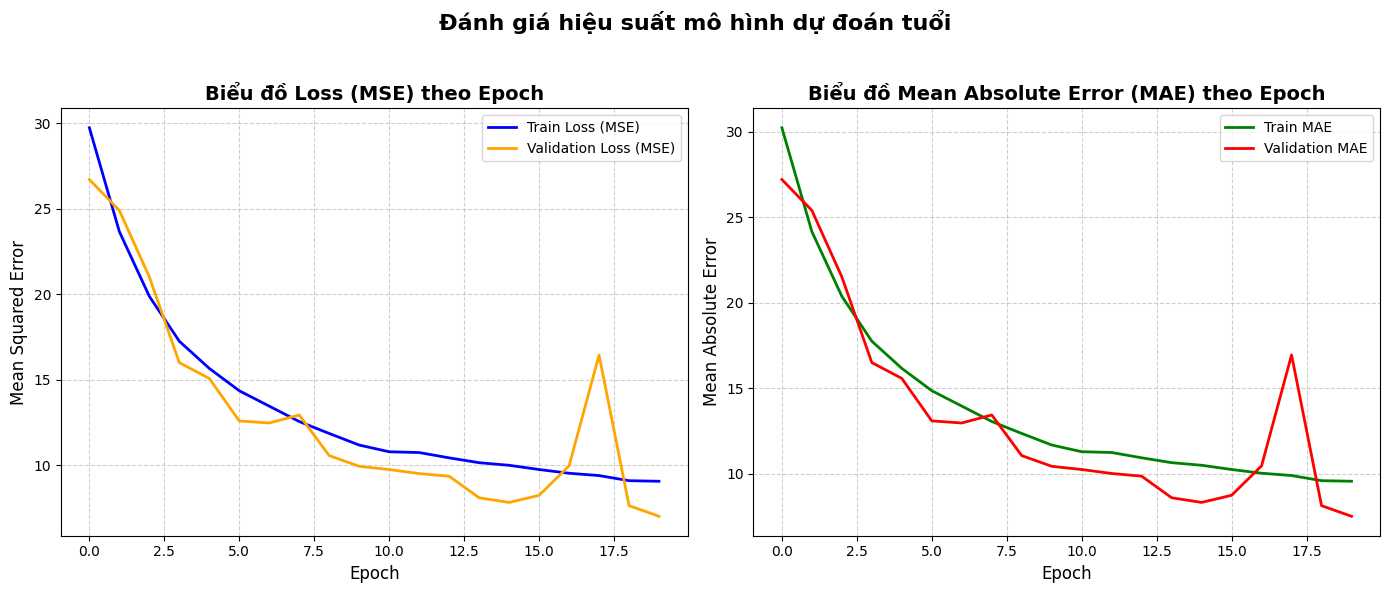

In [15]:
from matplotlib import pyplot as plt

plt.figure(figsize=(14,6))

# Biểu đồ Loss (Mean Squared Error)
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Train Loss (MSE)', color='blue', linewidth=2)
plt.plot(history1.history['val_loss'], label='Validation Loss (MSE)', color='orange', linewidth=2)
plt.title('Biểu đồ Loss (MSE) theo Epoch', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

# Biểu đồ MAE (Mean Absolute Error)
plt.subplot(1, 2, 2)
plt.plot(history1.history['mae'], label='Train MAE', color='green', linewidth=2)
plt.plot(history1.history['val_mae'], label='Validation MAE', color='red', linewidth=2)
plt.title('Biểu đồ Mean Absolute Error (MAE) theo Epoch', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Đánh giá hiệu suất mô hình dự đoán tuổi', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
MAE: 7.51
RMSE: 10.20
R² score: 0.80


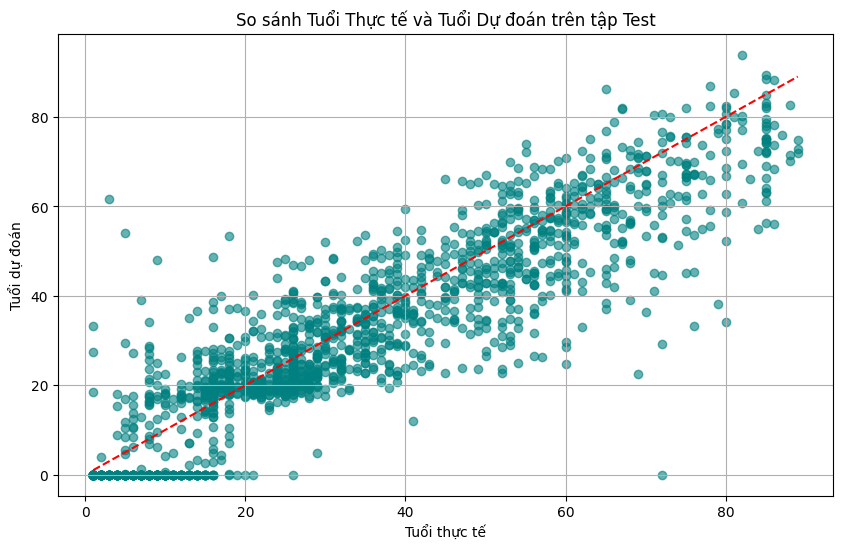

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

x_test_norm = x_test_age / 255.0
y_pred_age = agemodel.predict(x_test_norm).reshape(-1)
y_test_real = y_test_age.values.reshape(-1)

mae = mean_absolute_error(y_test_real, y_pred_age)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_age))
r2 = r2_score(y_test_real, y_pred_age)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² score: {r2:.2f}")

plt.figure(figsize=(10,6))
plt.scatter(y_test_real, y_pred_age, alpha=0.6, color='teal')
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--')
plt.xlabel('Tuổi thực tế')
plt.ylabel('Tuổi dự đoán')
plt.title('So sánh Tuổi Thực tế và Tuổi Dự đoán trên tập Test')
plt.grid(True)
plt.show()